### Pemodelan pergerakan harga saham Google dengan Deep Learning untuk prediksi
> Periode data yang diambil:  01 Januari 2015 - 07 Desember 2020
>
>Yang digunakan 800 observasi terakhir: 680 untuk training, 120 untuk testing
>
>https://finance.yahoo.com/quote/GOOG?p=GOOG


In [1]:
from numpy import *   
import numpy as np
from numpy.random import *
import pandas as pd
import scipy.stats
import statsmodels.api as sm
from tabulate import tabulate
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
%matplotlib inline

set_printoptions(precision = 3, suppress = True, formatter = {'float':'{:7.4f}'.format})

acf  = lambda y, lag: [corrcoef([y[:-t], y[t:]])[0,1] for t in arange(1, lag)]

def steps(x, step):
    obs  = len(x)-step
    xt   = x[:obs,:]
    for i in arange(1,step+1):
        xt = hstack((xt, x[i:obs+i,:]))
    return xt

In [2]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller Test:
        adfTest = adfuller(timeseries, autolag='AIC')
        self.pValue = adfTest[1]
        if (self.pValue < self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            
            #add critical value
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key]=value
                
            print('Dickey-Fuller Test Results')
            print(dfResults)

                 0
count  1494.000000
mean   1000.154595
std     298.606899
min     491.201416
25%     750.357499
50%    1025.320007
75%    1189.495025
max    1827.989990


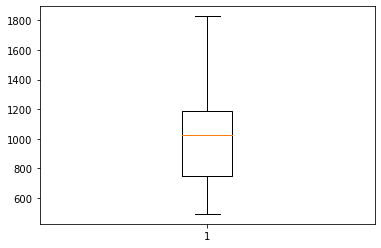

Dickey-Fuller Test Results
ADF Test Statistic        -0.013396
P-Value                    0.957410
# Lags Used                9.000000
# Observations Used     1484.000000
Critical Value (1%)       -3.434764
Critical Value (5%)       -2.863490
Critical Value (10%)      -2.567808
dtype: float64
Apakah data stasioner? False



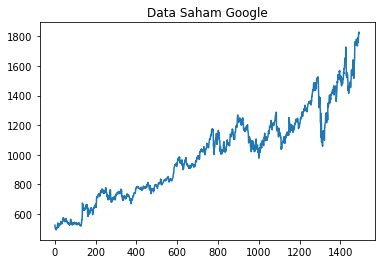

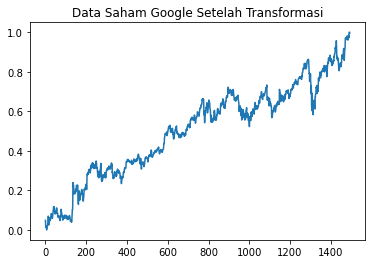

Autocorrelation function:
 [ 0.9985  0.9972  0.9959  0.9947  0.9935  0.9922  0.9912  0.9899  0.9890
  0.9878  0.9867  0.9858  0.9847  0.9838  0.9827  0.9818  0.9806  0.9794
  0.9781  0.9767  0.9755  0.9742  0.9731  0.9720]


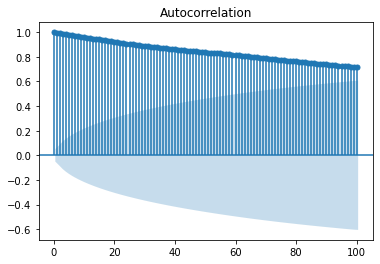

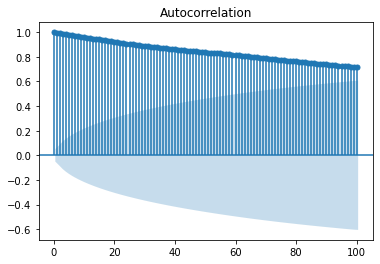

In [3]:
A = pd.read_excel('D:/Python Code/Ekonometrika/GOOG.xlsx').values  #Data time series harian harga saham Intel sejak 02 Januari 2015
B = (log(A[:,4:5].astype(float)))  #Kolom kelima isinya close price, 
                                   #dtype harus float dan list agar bisa dihitung acf-nya               

df = pd.DataFrame(A[:,4:5].astype(float))
print(df.describe(include='all'))
plt.boxplot(A[:,4:5].astype(float))
plt.show()

sTest = StationarityTests()
sTest.ADF_Stationarity_Test(A[:,4:5].astype(float),printResults = True)
print("Apakah data stasioner? {0}\n".format(sTest.isStationary))
    
Bmin = min(B)
Bmax = max(B)
b = (B-Bmin)/(Bmax-Bmin)
ACF = array(acf(b.squeeze(),25))

ts = 1   #Di literatur Time Series digunakan istilah 'lag' sebagai padanan istilah 'timestep' ini
xt = steps(b, ts)  #Dihasilkan matriks dengan 2 (= ts+1) kolom, kolom pertama menjadi variabel X
                   #dan kolom terkhir menjadi variabel y
x = xt[:,:-1]      #menghilangkan vektor terakhir, jadinya hanya satu kolom (vektor kolom)
x = hstack((ones([len(xt),1]), x))   #Ditambahkan vektor satuan, jadinya ada dua kolom (matriks)

#Data untuk training
X = x[690:1370, :]     #Ambil observasi agar diperoleh untuk varibel X sebanyak 620
y = xt[690:1370, -1:]  #Ambila kolom terakhir xt untuk dijadikan sebagai variabel y

#Data untuk testing
Xtest = x[1370:,:]      #ambil jumlah observasi sebanyak 120
ytest = xt[1370:, -1:]  #ambil kolom terakhir

plt.plot(A[:,4:5])
plt.title('Data Saham Google')
plt.show()

plt.plot(b)
plt.title('Data Saham Google Setelah Transformasi')
plt.show()

print('Autocorrelation function:\n', ACF)
sm.graphics.tsa.plot_acf(b,lags=100)

In [4]:
A[0:1]   #Observasi pertama dari data aslinya

array([[Timestamp('2015-01-02 00:00:00'), 527.561584, 529.815369,
        522.665039, 523.373108, 523.373108, 1447500]], dtype=object)

Sampai epoch ke 8000 dicapai akurasi MSE sebesar 0.0002552 dengan waktu 0:00:01.492008
MSE training: 0.0002552 
MSE testing : 0.0009275
Sampai epoch ke 16000 dicapai akurasi MSE sebesar 0.0002233 dengan waktu 0:00:03.060814
MSE training: 0.0002233 
MSE testing : 0.0005467
Sampai epoch ke 24000 dicapai akurasi MSE sebesar 0.0002153 dengan waktu 0:00:04.642583
MSE training: 0.0002153 
MSE testing : 0.0004390
Sampai epoch ke 32000 dicapai akurasi MSE sebesar 0.0002114 dengan waktu 0:00:06.194432
MSE training: 0.0002114 
MSE testing : 0.0003962
Sampai epoch ke 40000 dicapai akurasi MSE sebesar 0.0002093 dengan waktu 0:00:07.708383
MSE training: 0.0002093 
MSE testing : 0.0003866

Akurasi dengan data training: 0.0002093 



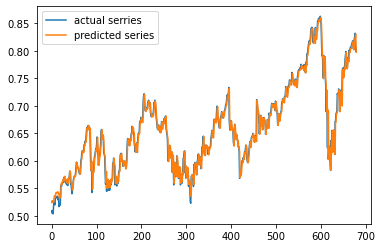

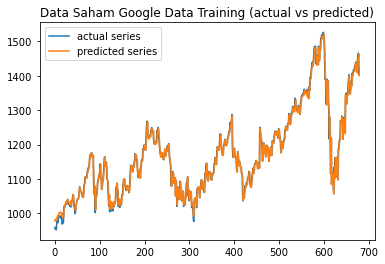

In [5]:
#Note best result: alpha = 3.5, H1 = 4, H2 = 4, ts =1;  
alpha = 5  #learning rate   
H1    = 5    #jumlah neurons di hidden layer ke 1  
H2    = 5    #jumlah neurons di hidden layer ke 2 

seed(20201202)
epochs = 40000  #proses belajar sebanyak epochs kali putaran
epoch  = 5       #akan ditampilkan hasil kemajuan belajar sebanyak 5 kali (boleh diganti-ganti)

[N, K] = shape(X)   #Ukuran matriks X
w0 = randn(K,H1)    #initial values untuk parameter w0 berupa normal(0,1,[K,H1])
w1 = randn(H1,H2)   #initial values untuk parameter w1 berupa normal(0,1,[H1,H2])
w2 = randn(H2,1)    #initial values untuk parameter w2 berupa normal(0,1,[H2,1])

tic = datetime.now()

yhat = zeros([len(y),epoch])  #Output akan disimpan sebanyak 5 (=epoch) kali
Cost = zeros([epoch])   #Cost function akan disimpan tiap beberapa saat 
i    = 0
for j in range(epochs):
    
    #forward propagation (perambatan maju)
   
    #Layer ke 1
    Z1 = X@w0             #reaksi kimia di layer ke 1
    A1 = 1/(1+exp(-Z1))   #arus listrik di layer ke 1 (output di layer ke 1)
    
    #Layer ke 2
    Z2 = A1@w1            #reaksi kimia di layer ke 2
    A2 = 1/(1+exp(-Z2))   #arus listrik di layer ke 2 (output di layer ke 2)
    
    
    #Layer ke 3 (output layer)
    Z3 = A2@w2   #reaksi kimia di layer ke 3
    A3 = 1/(1+exp(-Z3))   #Ini prediksi harga saham atau yhat (output di layer ke 3)
    
    
    #Backward propagation (perambatan mundur)
    
    #Layer 3
    e      = (y-A3)/sqrt(len(y))
    C      = e.T@e
    delta3 = -e*A3*(1-A3)
    dw2    = A2.T@delta3
    
    #Layer 2
    delta2 = delta3@w2.T*A2*(1-A2)
    dw1    = A1.T@delta2
    
    #Layer 1
    delta1 = delta2@w1.T*A1*(1-A1)
    dw0    = X.T@delta1
    
    #Parameters updating (ini jangan dilakukan sebelum selesai dihitung seluruh deltas)
    #Disinilah dilakukan rekaman pertambahan ilmu pengetahuan (knowledge) selama proses belajar
    
    w2 -= alpha*dw2   #Parameter w2 di-update 
    w1 -= alpha*dw1   #Parameter w1 di-update 
    w0 -= alpha*dw0   #Parameter w0 di-update 
    
    if (j+1)%((epochs)/epoch) == 0:
        yhat[:,i] = A3.squeeze()   #prediksi model disimpan 5 (=epoch) kali saja bila diperlukan untuk di-plot
        Cost[i] = C
        print("Sampai epoch ke", j+1,"dicapai akurasi MSE sebesar %8.7f" %C,"dengan waktu", datetime.now()-tic)
        #Layer ke 1
        Z1 = Xtest@w0
        A1 = 1/(1+exp(-Z1))
        #Layer ke 2
        Z2 = A1@w1
        A2 = 1/(1+exp(-Z2))
        #Layer ke 3
        Z3 = A2@w2
        ytesthat = 1/(1+exp(-Z3))   #Prediksi harga saham
        mse = (y-A3).T@(y-A3)/len(y)   #MSE semasa training
        msetest = (ytest-ytesthat).T@(ytest-ytesthat)/len(ytest)   #MSE semasa testing
        print('MSE training: %8.7f'%mse,'\nMSE testing : %7.7f'%msetest)
        i += 1

toc = datetime.now()
print('\nAkurasi dengan data training: %8.7f' %C,'\n')

ytraino = exp(y*(Bmax-Bmin)+Bmin)         #Kembalikan datanya ke original unit dalam satuan dolar
ytrainhato = exp(A3*(Bmax-Bmin)+Bmin)   #Kembalikan datanya ke original unit dalam satuan dolar

plt.plot(y, label = 'actual serries')
plt.plot(yhat[:,epoch-1], label = 'predicted series')
plt.legend()
plt.show()

plt.plot(ytraino, label = 'actual series')
plt.plot(ytrainhato, label = 'predicted series')
plt.title('Data Saham Google Data Training (actual vs predicted)')
plt.legend()
plt.show()

MSE training: 0.0002093 
MSE testing : 0.0003866


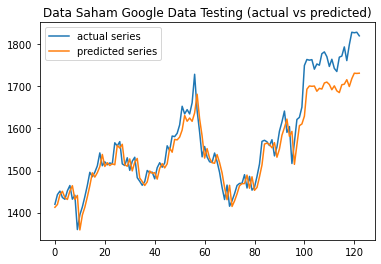

In [6]:
#Parameters w0, w1 dan w2 sebagai ilmu pengetahuan atau knowledge yang diperoleh selama training 
#akan digunakan disini untuk di-test kemampuannya memprediksi. 
#Data yang dipakai Xtest dan ytest yang tidak digunakan selama training.

#Layer ke 1
Z1 = Xtest@w0
A1 = 1/(1+exp(-Z1))

#Layer ke 2
Z2 = A1@w1
A2 = 1/(1+exp(-Z2))

#Layer ke 3
Z3 = A2@w2
ytesthat = 1/(1+exp(-Z3))   #Prediksi harga saham

mse = (y-A3).T@(y-A3)/len(y)   #MSE semasa training
msetest = (ytest-ytesthat).T@(ytest-ytesthat)/len(ytest)   #MSE semasa testing
print('MSE training: %8.7f'%mse,'\nMSE testing : %7.7f'%msetest)

ytesto = exp(ytest*(Bmax-Bmin)+Bmin)         #Kembalikan datanya ke original unit dalam satuan dolar
ytesthato = exp(ytesthat*(Bmax-Bmin)+Bmin)   #Kembalikan datanya ke original unit dalam satuan dolar
plt.plot(ytesto, label = 'actual series')
plt.plot(ytesthato, label = 'predicted series')
plt.title('Data Saham Google Data Testing (actual vs predicted)')
plt.legend()
plt.show()

In [7]:
len(y),len(ytest)

(680, 123)